<a href="https://colab.research.google.com/github/Frans-Grau/ElectricVehicleVsChargingStations/blob/main/EVPopulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install pyspark

In [3]:
import pandas as pd
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("EVPop").getOrCreate()

In [4]:
url = "https://raw.githubusercontent.com/Frans-Grau/ElectricVehicleVsChargingStations/main/Databases/EVPopulation.csv"
from pyspark import SparkFiles
spark.sparkContext.addFile(url)

dfEV = spark.read.csv("file://"+SparkFiles.get("EVPopulation.csv"), header=True, inferSchema= True)

In [5]:
dfEV.show(1)

+----------+------+-------+-----+-----------+----------+-------------+---------+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+--------------------+----------------+-----------------+
|VIN (1-10)|County|   City|State|Postal Code|Model Year|         Make|    Model|Electric Vehicle Type|Clean Alternative Fuel Vehicle (CAFV) Eligibility|Electric Range|Base MSRP|Legislative District|DOL Vehicle ID|    Vehicle Location|Electric Utility|2020 Census Tract|
+----------+------+-------+-----+-----------+----------+-------------+---------+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+--------------------+----------------+-----------------+
|WDC0G5EB7K|Louisa|Bumpass|   VA|      23024|      2019|MERCEDES-BENZ|GLC-CLASS| Plug-in Hybrid El...|                             Not eligible due ...|            10|        0|             

In [6]:
dfEV.printSchema()

root
 |-- VIN (1-10): string (nullable = true)
 |-- County: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postal Code: integer (nullable = true)
 |-- Model Year: integer (nullable = true)
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Electric Vehicle Type: string (nullable = true)
 |-- Clean Alternative Fuel Vehicle (CAFV) Eligibility: string (nullable = true)
 |-- Electric Range: integer (nullable = true)
 |-- Base MSRP: integer (nullable = true)
 |-- Legislative District: integer (nullable = true)
 |-- DOL Vehicle ID: integer (nullable = true)
 |-- Vehicle Location: string (nullable = true)
 |-- Electric Utility: string (nullable = true)
 |-- 2020 Census Tract: long (nullable = true)



## EDA on the filtered DF -> State = Washington

In [49]:
### Filter dfEV to just values in WA and save into a new dataframe
df1 = dfEV.filter(dfEV.State == 'WA')


In [51]:
### Check for Null values -> the whole df
from pyspark.sql.functions import isnan, when, count, col, isnull
df1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df1.columns]).show()

+----------+------+----+-----+-----------+----------+----+-----+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+
|VIN (1-10)|County|City|State|Postal Code|Model Year|Make|Model|Electric Vehicle Type|Clean Alternative Fuel Vehicle (CAFV) Eligibility|Electric Range|Base MSRP|Legislative District|DOL Vehicle ID|Vehicle Location|Electric Utility|2020 Census Tract|
+----------+------+----+-----+-----------+----------+----+-----+---------------------+-------------------------------------------------+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+
|         0|     0|   0|    0|          0|         0|   0|   84|                    0|                                                0|             0|        0|                   0|             0|              27|             159|                0|


In [53]:
### Check for null values -> 1 column at a time 
from pyspark.sql.functions import col 
df1.filter(col('Model').isNull()).count()

84

In [55]:
### Compare SIZE after removing all nulls
dfWA = df1.na.drop()
print('df1 - Original: ', (df1).count(), len(df1.columns))
print('dfWA - Without Null values: ', (dfWA).count(), len(dfWA.columns))

df1 - Original:  114312 17
dfWA - Without Null values:  114042 17


In [56]:
### County information
dfWA.groupBy('County').count().orderBy('count', ascending=False).show()

+------------+-----+
|      County|count|
+------------+-----+
|        King|60005|
|   Snohomish|12686|
|      Pierce| 8670|
|       Clark| 6824|
|    Thurston| 4179|
|      Kitsap| 3880|
|     Whatcom| 2873|
|     Spokane| 2828|
|      Benton| 1394|
|      Island| 1297|
|      Skagit| 1240|
|     Clallam|  737|
|    San Juan|  724|
|   Jefferson|  699|
|      Chelan|  653|
|      Yakima|  633|
|     Cowlitz|  575|
|       Mason|  554|
|       Lewis|  437|
|Grays Harbor|  397|
+------------+-----+
only showing top 20 rows



In [57]:
### City Information
dfWA.groupBy('City').count().orderBy('count', ascending=False).show()

+-------------+-----+
|         City|count|
+-------------+-----+
|      Seattle|20591|
|     Bellevue| 5986|
|      Redmond| 4279|
|    Vancouver| 4106|
|     Kirkland| 3636|
|      Bothell| 3404|
|    Sammamish| 3370|
|       Renton| 2855|
|      Olympia| 2776|
|       Tacoma| 2407|
|   Bellingham| 1980|
|     Issaquah| 1827|
|      Spokane| 1697|
|Mercer Island| 1668|
|  Woodinville| 1622|
|         Kent| 1620|
|      Everett| 1518|
|     Lynnwood| 1501|
|    Snohomish| 1349|
|      Edmonds| 1299|
+-------------+-----+
only showing top 20 rows



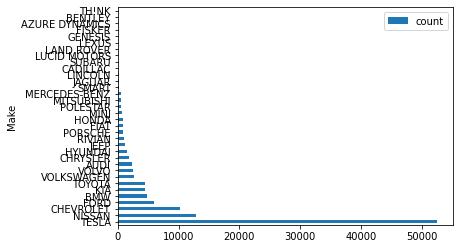

In [76]:
### Value Counts and use pnadas to plot
models = dfWA.groupBy('Make').count().orderBy('count', ascending=False)
p_models = models.toPandas()
p_models = p_models.set_index('Make')
p_models.plot(kind='barh')